In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import pickle
from pathlib import Path

import numpy as np

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from time import perf_counter  # noqa

from mcmc import MCMC  # noqa
from mcmc.utils.plot import plot_summary_stats  # noqa
from mcmc.system import SurfaceSystem  # noqa
from mcmc.utils import setup_logger  # noqa

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "GaN_0001"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Initialize logger
logger = setup_logger("mcmc", run_folder / "mc.log", logging.INFO)

# Load prepared pristine slab
try:
    with open("data/GaN_0001/GaN_0001_3x3_pristine_slab.pkl", "rb") as f:
        slab = pickle.load(f)
except FileNotFoundError as e:
    print("Pristine surface pkl file not found. Please check you have downloaded the data.")
    raise e

calc_settings = {
    "calc_name": "LAMMPS",
    "optimizer": "LAMMPS",
    "chem_pots": {"Ga": 5},  # eV. arbitrary value
    "relax_atoms": True,
    "relax_steps": 100,
    "run_dir": run_folder,
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
    "ads_site_type": "all",
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 104,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": True,
    "alpha": 0.99,  # slowly anneal
    "canonical": True,
    "num_ads_atoms": 12,
    "adsorbates": ["Ga"],
    "run_folder": run_folder,
}

Set up LAMMPS (calculator). Requires a `lammps_config.json` and a `lammps_template.txt` in `run_dir`

In [4]:
from mcmc.calculators import LAMMPSSurfCalc

lammps_surf_calc = LAMMPSSurfCalc()
lammps_surf_calc.set(**calc_settings)

19:51:07 - mcmc.calculators | INFO: run directory: GaN_0001 is set from parameters
19:51:07 - mcmc.calculators | INFO: relaxation steps: 100 is set from parameters


/home/dux/NeuralForceField/models


{'calc_name': 'LAMMPS',
 'optimizer': 'LAMMPS',
 'chem_pots': {'Ga': 5},
 'relax_atoms': True,
 'relax_steps': 100,
 'run_dir': PosixPath('GaN_0001')}

Initialize surface system

In [5]:
surface = SurfaceSystem(
    slab,
    calc=lammps_surf_calc,
    system_settings=system_settings,
    save_folder=run_folder,
)
surface.all_atoms.write(run_folder / "GaN_0001_3x3_all_virtual_ads.cif")

19:51:07 - mcmc.system | INFO: Initalizing adsorption sites with settings: {'surface_name': 'GaN_0001', 'surface_depth': 1, 'cutoff': 5.0, 'near_reduce': 0.01, 'planar_distance': 1.5, 'no_obtuse_hollow': True, 'ads_site_type': 'all'}
19:51:08 - mcmc.system | INFO: Generated adsorption coordinates are: [array([ 0.   ,  0.   , 14.766]), array([12.865,  7.428, 14.12 ]), array([12.865,  5.571, 14.766]), array([11.257,  4.642, 14.12 ]), array([ 1.608,  2.785, 14.766])]...
19:51:08 - mcmc.system | INFO: Initializing 107 virtual atoms
19:51:08 - mcmc.system | INFO: Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
19:51:08 - mcmc.system | INFO: Number of pristine atoms is 36
19:51:08 - mcmc.system | INFO: Bulk indices are [ 1  2  3  5  6  7  9 10 11 13 14 15 17 18 19 21 22 23 25 26 27 29 30 31
 33 34 35]
19:51:

Total wall time: 0:00:00


Test calculate pristine surface

In [6]:
print(f"Energy {surface.get_potential_energy():.3f} eV")

19:51:09 - mcmc.calculators | INFO: None


Energy -144.059 eV
Total wall time: 0:00:00


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `GaN(0001)/` folder.

19:51:09 - mcmc.mcmc | INFO: Using run folder GaN_0001
19:51:09 - mcmc.mcmc | INFO: randomly adsorbing sites
19:51:09 - mcmc.events.criterion | ERROR: No surface energy found in results dict
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:09 - mcmc.calculators | INFO: None
19:51:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:10 - mcmc.mcmc | INFO: There are 36 atoms in pristine slab
19:51:10 - mcmc.mcmc | INFO: Running with num_sweeps = 10, sweep_size = 104, start_temp = 1.000
19:51:10 - mcmc.mcmc | INFO: Starting with iteration 0
19:51:10 - mcmc.mcmc | INFO: Temperature schedule is: ['1.000', '0.990', '0.980', '0.970', '0.961', '0.951', '0.941', '0.932', '0.923', '0.914']
19:51:10 - mcmc.mcmc | INFO: In sweep 1 out of 10
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:10 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None
19:51:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None
19:51:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None
19:51:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None
19:51:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:14 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None
19:51:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:15 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:16 - mcmc.calculators | INFO: None
19:51:16 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.mcmc | INFO: At iter 104
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.system | INFO: Optimized structure has Energy = -176.742


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:17 - mcmc.mcmc | INFO: In sweep 2 out of 10
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:17 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None
19:51:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:18 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:19 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None
19:51:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:21 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None
19:51:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None
19:51:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:23 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:24 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.mcmc | INFO: At iter 208
19:51:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.system | INFO: Optimized structure has Energy = -177.200
19:51:25 - mcmc.mcmc | INFO: In sweep 3 out of 10
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None
19:51:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:26 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None
19:51:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:28 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:29 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:30 - mcmc.calculators | INFO: None
19:51:30 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:31 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.mcmc | INFO: At iter 312
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.calculators | INFO: None
19:51:32 - mcmc.system | INFO: Optimized structure has Energy = -176.863


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:32 - mcmc.mcmc | INFO: In sweep 4 out of 10
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:33 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None
19:51:34 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:34 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:35 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None
19:51:36 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:37 - mcmc.calculators | INFO: None
19:51:37 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:38 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None
19:51:39 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.mcmc | INFO: At iter 416
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.system | INFO: Optimized structure has Energy = -176.906
19:51:40 - mcmc.mcmc | INFO: In sweep 5 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:40 - mcmc.calculators | INFO: None
19:51:40 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None
19:51:41 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:42 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:43 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:44 - mcmc.calculators | INFO: None
19:51:44 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:45 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:46 - mcmc.calculators | INFO: None
19:51:46 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.mcmc | INFO: At iter 520
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.calculators | INFO: None
19:51:47 - mcmc.system | INFO: Optimized structure has Energy = -177.549
19:51:47 - mcmc.mcmc | INFO: In sweep 6 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None
19:51:48 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:49 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:50 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None
19:51:51 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:52 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:53 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.mcmc | INFO: At iter 624
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.system | INFO: Optimized structure has Energy = -173.265
19:51:54 - mcmc.mcmc | INFO: In sweep 7 out of 10


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:54 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:55 - mcmc.calculators | INFO: None
19:51:55 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None
19:51:56 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None
19:51:57 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:58 - mcmc.calculators | INFO: None
19:51:58 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:51:59 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None
19:52:00 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:00 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:01 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None
19:52:02 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:02 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.mcmc | INFO: At iter 728


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.system | INFO: Optimized structure has Energy = -177.402
19:52:03 - mcmc.mcmc | INFO: In sweep 8 out of 10
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:03 - mcmc.calculators | INFO: None
19:52:03 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None
19:52:04 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:05 - mcmc.calculators | INFO: None
19:52:05 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None
19:52:06 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:07 - mcmc.calculators | INFO: None
19:52:07 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:08 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:09 - mcmc.calculators | INFO: None
19:52:09 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:10 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.mcmc | INFO: At iter 832


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.system | INFO: Optimized structure has Energy = -177.385
19:52:11 - mcmc.mcmc | INFO: In sweep 9 out of 10
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:11 - mcmc.calculators | INFO: None
19:52:11 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None
19:52:12 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None
19:52:13 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:14 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:15 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:16 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None
19:52:17 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None
19:52:18 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:18 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.mcmc | INFO: At iter 936
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.system | INFO: Optimized structure has Energy = -175.839


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:19 - mcmc.mcmc | INFO: In sweep 10 out of 10
19:52:19 - mcmc.calculators | INFO: None
19:52:19 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:20 - mcmc.calculators | INFO: None
19:52:20 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:21 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None
19:52:22 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None
19:52:23 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:23 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None
19:52:24 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:24 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None
19:52:25 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None
19:52:26 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:26 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:27 - mcmc.calculators | INFO: None
19:52:28 - mcmc.calculators | INFO: None


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00


19:52:28 - mcmc.calculators | INFO: None
19:52:28 - mcmc.mcmc | INFO: At iter 1040
19:52:28 - mcmc.calculators | INFO: None
19:52:28 - mcmc.calculators | INFO: None
19:52:28 - mcmc.calculators | INFO: None
19:52:28 - mcmc.system | INFO: Optimized structure has Energy = -178.757


Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Total wall time: 0:00:00
Time taken = 78.917 seconds


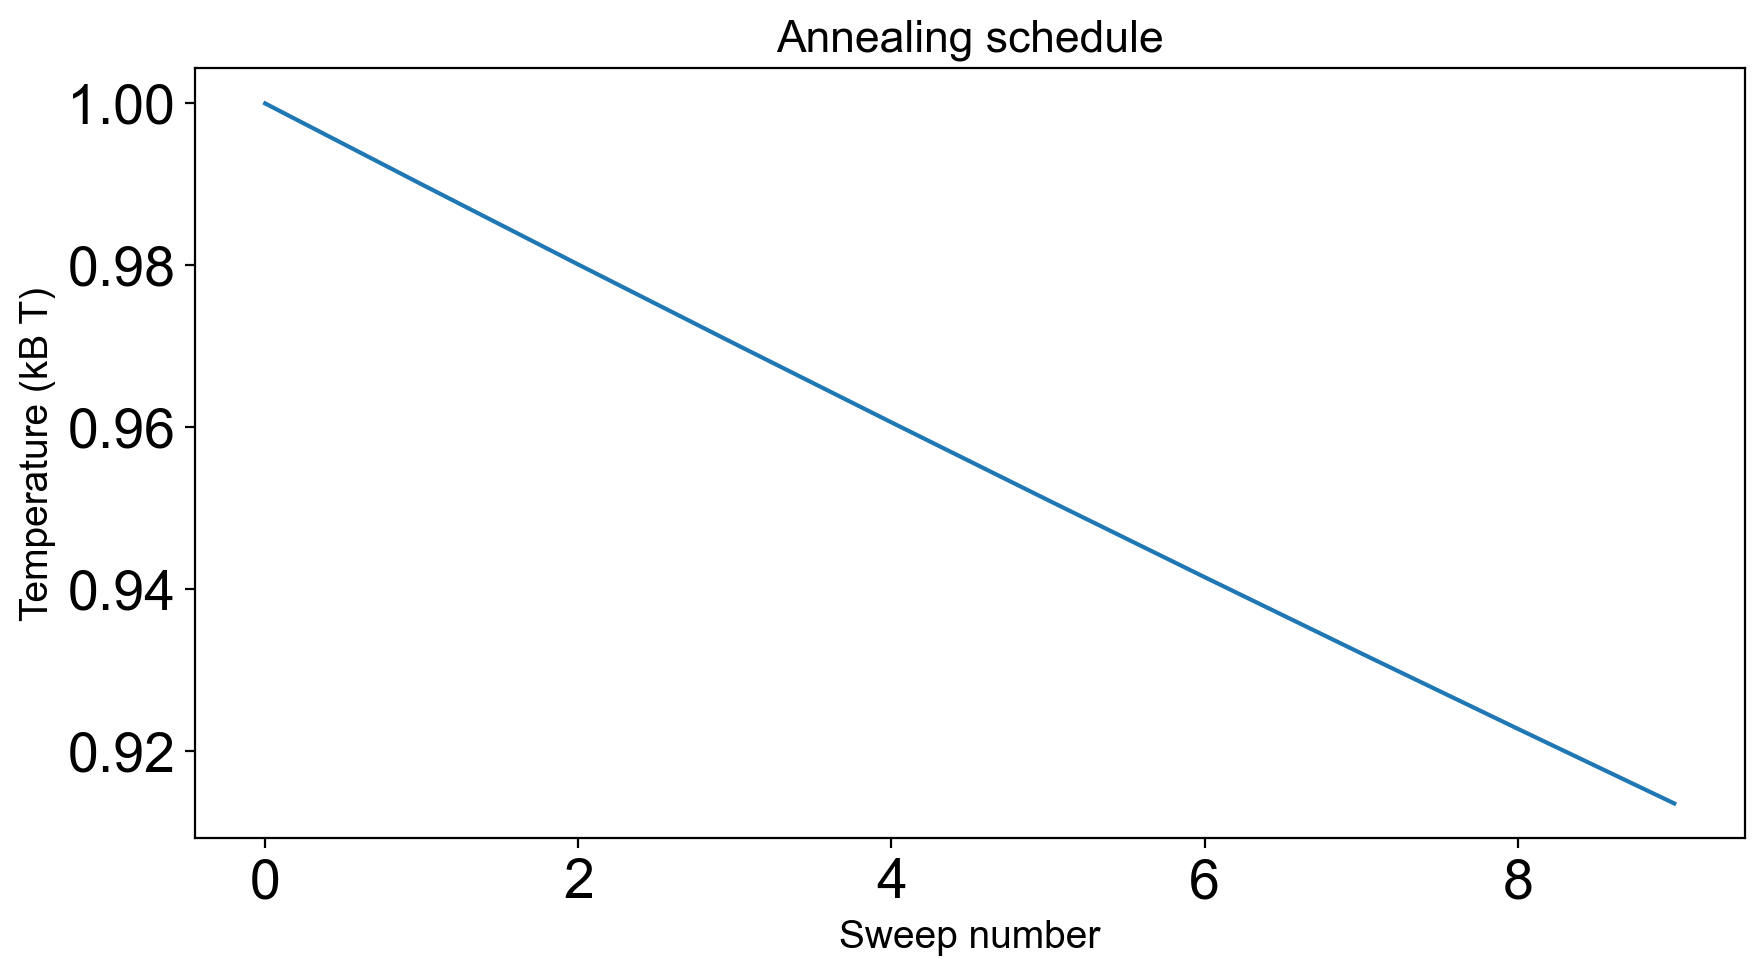

In [7]:
mcmc = MCMC(**sampling_settings)

start = perf_counter()
results = mcmc.run(
    surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

Plot results

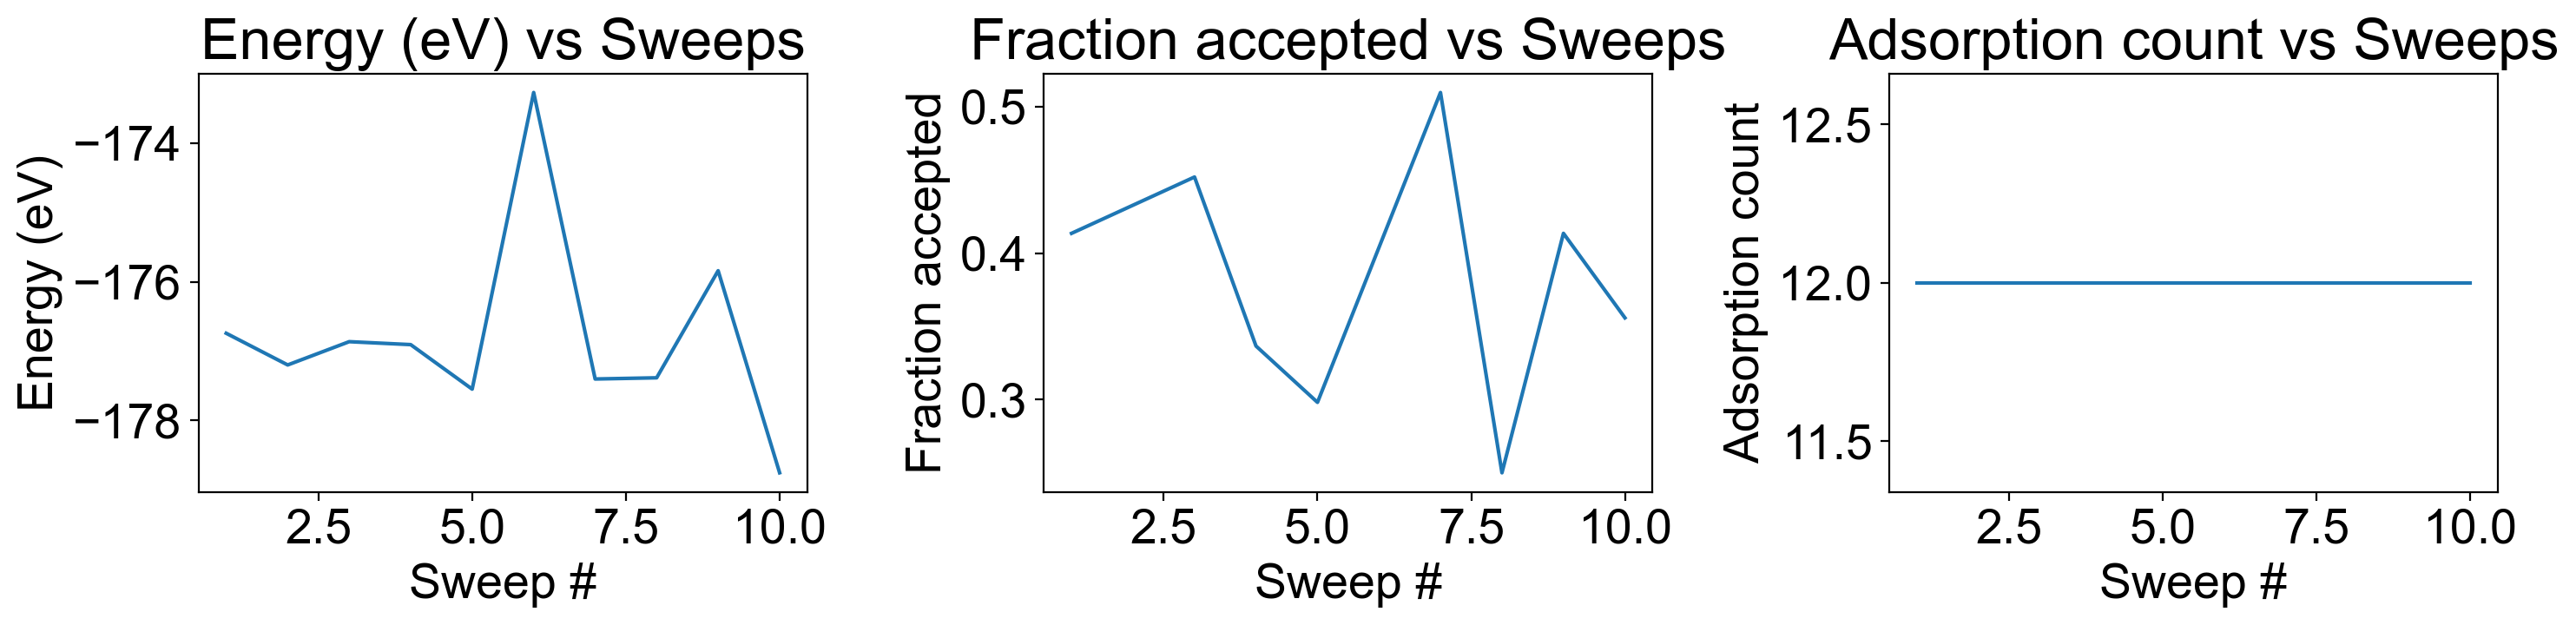

In [8]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)